In [6]:
pip install matplotlib
pip install networkx
pip install pandas

SyntaxError: invalid syntax (<ipython-input-6-ab6d592d883b>, line 1)

In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
with open('./dati-json/dpc-covid19-ita-province.json') as f:
    covid19_provinces_data = json.load(f)

with open('./dati-json/dpc-covid19-ita-regioni.json') as f:
    covid19_regions_data = json.load(f)

In [10]:
data = []
for province in covid19_provinces_data:
    province_denomination = province['sigla_provincia']
    province_date = province['data']
    # Es. ('FI', '2020-02-24T...', all data on that row)
    # the first 2 values will be used as key
    data.append([province_denomination, province_date, province.values()]) 

# Sort according to the date
data = sorted(data, key=lambda x: x[0])
# Prepare data for the DataFrame
index = []
province_info = []
for province in data:
    index.append([province[0], province[1]]) # (Name, date)
    province_info.append(province[2]) # (codice_regione, codice_provincia, ...)
index = pd.MultiIndex.from_tuples(index) # Index ranking: 1° City's name, 2° date
# Create finally the DataFrame
dati = pd.DataFrame(province_info, index=index, columns=covid19_provinces_data[0].keys())
# and drop some usless columns
dati = dati.drop(columns=['codice_regione', 'denominazione_provincia', 'stato', 'codice_provincia', 'note_it', 'note_en'])
dati

data denominazione_regione  \
   2020-02-24T18:00:00  2020-02-24T18:00:00               Abruzzo   
   2020-02-24T18:00:00  2020-02-24T18:00:00            Basilicata   
   2020-02-24T18:00:00  2020-02-24T18:00:00          P.A. Bolzano   
   2020-02-24T18:00:00  2020-02-24T18:00:00              Calabria   
   2020-02-24T18:00:00  2020-02-24T18:00:00              Campania   
...                                     ...                   ...   
VV 2020-05-15T17:00:00  2020-05-15T17:00:00              Calabria   
   2020-05-16T17:00:00  2020-05-16T17:00:00              Calabria   
   2020-05-17T17:00:00  2020-05-17T17:00:00              Calabria   
   2020-05-18T17:00:00  2020-05-18T17:00:00              Calabria   
   2020-05-19T17:00:00  2020-05-19T17:00:00              Calabria   

                       sigla_provincia        lat       long  totale_casi  
   2020-02-24T18:00:00                   0.000000   0.000000            0  
   2020-02-24T18:00:00                   0.000000   0.000000            0  
   2020-02-24T18:00:00                   0.000000   0.000000            0  
   2020-02-24T18:00:00                   0.000000   0.000000            0  
   2020-02-24T18:00:00                   0.000000   0.000000            0  
...                                ...        ...        ...          ...  
VV 2020-05-15T17:00:00              VV  38.676241  16.101574           77  
   2020-05-16T17:00:00              VV  38.676241  16.101574           81  
   2020-05-17T17:00:00              VV  38.676241  16.101574           81  
   2020-05-18T17:00:00              VV  38.676241  16.101574           81  
   2020-05-19T17:00:00              VV  38.676241  16.101574           81  

[11008 rows x 6 columns]

Text(0.5, 1.0, 'Top 20 provinces with most cases')

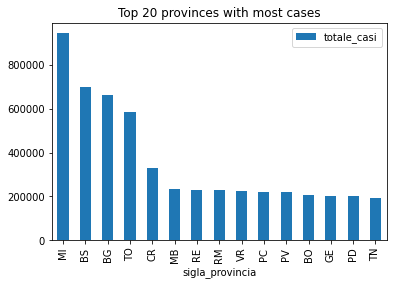

In [11]:
# group by "sigla_provincia" and sum all the values. Then drop 'lat' and 'long' columns and show 
# the top 15 provinces with the highest value on 'totale_casi'
dati.groupby(['sigla_provincia']).sum().drop(columns=['lat', 'long']).nlargest(15, 'totale_casi').plot(kind="bar")
plt.title("Top 20 provinces with most cases") # I don't know why this 'plt.title()' is working 
#but the others right below don't

In [12]:
# Get the provinces name (Sigle)
provinces = dati.sigla_provincia.unique()
# Create a DataFrame with total cases per month for each province
cases_per_month = {}

for province in provinces: 
    province_info = dati.loc[province]
    # The 'groupby(province_info.data.str[:7]' is used to group the rows according to the month
    # The [:7] is used to slice the first t letters of the 'data' column
    # 2020-05-15T17:00:00 ---> 2020-05
    # And finally sum the 'totale_casi' values grouped by month for each province
    cases_per_month[province] = pd.Series(province_info.groupby(province_info.data.str[:7])['totale_casi'].sum())

# Create the DataFrame using the Series defined in the for loop
cpm = pd.DataFrame(cases_per_month)
cpm.index.name = "" # Works fine even without this line, but there was an empty line that was bothering me
cpm = cpm.T # For a better view
cpm

,2020-02,2020-03,2020-04,2020-05
,198,39032,86204,60379
AG,0,878,3697,2615
AL,0,14258,74646,70245
AN,0,12655,47962,34855
AO,0,6155,28725,21967
...,...,...,...,...
VE,63,14442,58689,48967
VI,9,12855,63618,52510
VR,0,20883,108498,93385
VT,0,1697,9546,7749


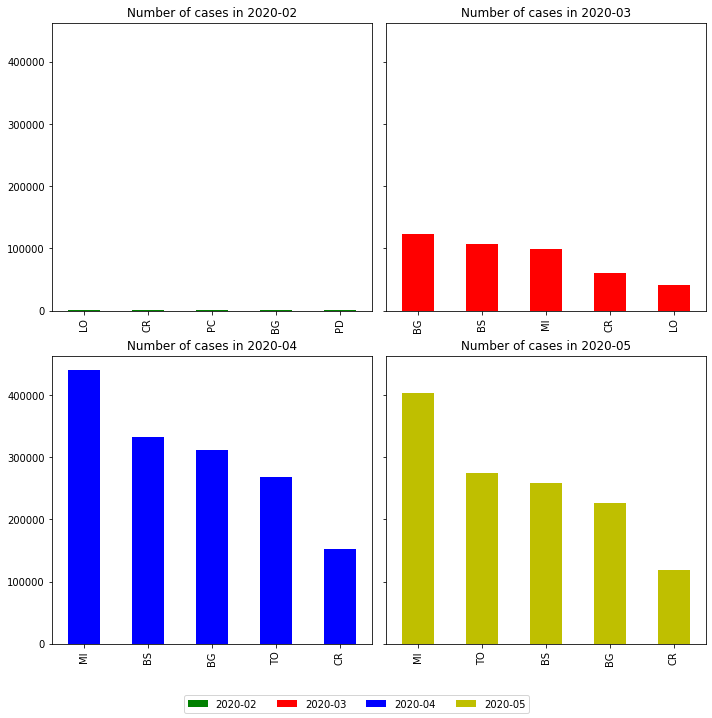

In [13]:
grid_size = (2,2) # For the 4 month considered
colors = ['g', 'r', 'b', 'y']
fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], sharey=True, figsize=(10,10))
cities_with_worst_cases = [] # Store the name of the cities with the worst cases

month = 0
for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        # Cities twith the worst cases in the current month
        worst_cases = cpm.nlargest(5, cpm.columns[month])[cpm.columns[month]]
        worst_cases.plot(ax=axes[i,j], kind='bar', legend=False, color=colors[month])
        axes[i, j].set_title('Number of cases in '+cpm.columns[month]) # Doesn't work
        cities_with_worst_cases.append(worst_cases)
        month += 1
        
fig.tight_layout()
fig.subplots_adjust(bottom=0.1)
fig.legend(labels=cpm.columns, loc="lower center", ncol=4)

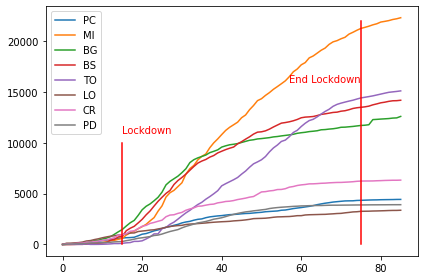

In [11]:
# Create a set of the cities with the worst case 
interested_city = list(set([item for sublist in [list(city.index) for city in cities_with_worst_cases] for item in sublist]))


# Collect information about these cities day by day
for i in range(len(interested_city)):
    case_per_day = dati.loc[interested_city[i]]['totale_casi']
    plt.plot(list(range(len(case_per_day))), case_per_day, label=interested_city[i])

plt.ylabel ="number of cases"
plt.plot((15, 15), (0, 10000), 'r-')
plt.text(15, 11000, "Lockdown", color="r")
plt.plot((75, 75), (0, 22000), 'r-')
plt.text(57, 16000, "End Lockdown", color="r")
plt.tight_layout()
plt.legend()


In [354]:
covid19_provinces_data

[{'data': '2020-02-24T18:00:00',
  'stato': 'ITA',
  'codice_regione': 13,
  'denominazione_regione': 'Abruzzo',
  'codice_provincia': 69,
  'denominazione_provincia': 'Chieti',
  'sigla_provincia': 'CH',
  'lat': 42.35103167,
  'long': 14.16754574,
  'totale_casi': 0,
  'note_it': '',
  'note_en': ''},
 {'data': '2020-02-24T18:00:00',
  'stato': 'ITA',
  'codice_regione': 13,
  'denominazione_regione': 'Abruzzo',
  'codice_provincia': 66,
  'denominazione_provincia': "L'Aquila",
  'sigla_provincia': 'AQ',
  'lat': 42.35122196,
  'long': 13.39843823,
  'totale_casi': 0,
  'note_it': '',
  'note_en': ''},
 {'data': '2020-02-24T18:00:00',
  'stato': 'ITA',
  'codice_regione': 13,
  'denominazione_regione': 'Abruzzo',
  'codice_provincia': 68,
  'denominazione_provincia': 'Pescara',
  'sigla_provincia': 'PE',
  'lat': 42.46458398,
  'long': 14.21364822,
  'totale_casi': 0,
  'note_it': '',
  'note_en': ''},
 {'data': '2020-02-24T18:00:00',
  'stato': 'ITA',
  'codice_regione': 13,
  'deno

In [220]:
# For tomorrow maybe



dataframe_data = {}
for region in covid19_regions_data:
    region_denomination = region['denominazione_regione']
    regions_data = pd.Series(region)
    dataframe_data[region_denomination] = regions_data
regions_data_frame = pd.DataFrame(dataframe_data).T
regions_data_frame.drop(columns=['data', 'denominazione_regione', 'stato', 'note_it', 'note_en'])

,codice_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati
Abruzzo,13,42.3512,13.3984,188,6,194,1195,1389,-24,4,1419,389,3197,58945,41162
Basilicata,17,40.6395,15.8051,26,1,27,57,84,-9,1,282,27,393,23347,22767
P.A. Bolzano,21,46.4993,11.3566,46,6,52,256,308,1,5,1988,291,2587,55526,25263
Calabria,18,38.906,16.5944,50,2,52,330,382,-19,2,676,95,1153,57310,55270
Campania,15,40.8396,14.2508,330,17,347,1171,1518,-155,12,2790,399,4707,147225,69264
Emilia-Romagna,8,44.4944,11.3417,670,99,769,4561,5330,-195,47,17987,3997,27314,268200,168367
Friuli Venezia Giulia,6,45.6494,13.7681,76,2,78,522,600,-21,5,2283,320,3203,105656,65476
Lazio,12,41.8928,12.4837,1124,74,1198,2588,3786,-40,20,3079,640,7505,213877,171353
Liguria,7,44.4115,8.9327,338,22,360,1904,2264,-75,66,5617,1376,9257,83593,49038
Lombardia,3,45.4668,9.19035,4426,244,4670,22621,27291,218,462,42593,15597,85481,596355,353579


In [5]:
covid19_regions_data

[{'data': '2020-02-24T18:00:00',
  'stato': 'ITA',
  'codice_regione': 13,
  'denominazione_regione': 'Abruzzo',
  'lat': 42.35122196,
  'long': 13.39843823,
  'ricoverati_con_sintomi': 0,
  'terapia_intensiva': 0,
  'totale_ospedalizzati': 0,
  'isolamento_domiciliare': 0,
  'totale_positivi': 0,
  'variazione_totale_positivi': 0,
  'nuovi_positivi': 0,
  'dimessi_guariti': 0,
  'deceduti': 0,
  'totale_casi': 0,
  'tamponi': 5,
  'casi_testati': None,
  'note_it': '',
  'note_en': ''},
 {'data': '2020-02-24T18:00:00',
  'stato': 'ITA',
  'codice_regione': 17,
  'denominazione_regione': 'Basilicata',
  'lat': 40.63947052,
  'long': 15.80514834,
  'ricoverati_con_sintomi': 0,
  'terapia_intensiva': 0,
  'totale_ospedalizzati': 0,
  'isolamento_domiciliare': 0,
  'totale_positivi': 0,
  'variazione_totale_positivi': 0,
  'nuovi_positivi': 0,
  'dimessi_guariti': 0,
  'deceduti': 0,
  'totale_casi': 0,
  'tamponi': 0,
  'casi_testati': None,
  'note_it': '',
  'note_en': ''},
 {'data': '